In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

In [3]:
print(tensorflow.__version__)

2.3.0


In [4]:
# for GPU and not to overclock it which means that 50% of the GPU will be used and tensorflow, maybe won't be able to give proper results.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [9]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [6]:
train_path = 'D:\ML_workspace\cotton_prediction\datasets\train'
test_path = 'D:\ML_workspace\cotton_prediction\datasets\test'

In [7]:
image_size = [224,224]

In [10]:
resnet = ResNet50(input_shape = image_size + [3], weights = 'imagenet', include_top = False)

94773248/94765736 [==============================] - 40s 0us/step


In [12]:
# in the previous step we work with the pretrained weights from the imagenet model.
# imagenet already has 1000 categories with different images.
# 90 MB file.
# And we also set the include_top to false because we are setting up the image size on our own i.e.,[224,224].

# include_top, the first and the last layer are removed.
# so we have to not train the model entirely

In [13]:
for layer in resnet.layers:
    layer.trainable = False

In [16]:
folders = glob(r'D:\ML_workspace\cotton_prediction\datasets\train\*')

In [17]:
folders

['D:\\ML_workspace\\cotton_prediction\\datasets\\train\\diseased cotton leaf',
 'D:\\ML_workspace\\cotton_prediction\\datasets\\train\\diseased cotton plant',
 'D:\\ML_workspace\\cotton_prediction\\datasets\\train\\fresh cotton leaf',
 'D:\\ML_workspace\\cotton_prediction\\datasets\\train\\fresh cotton plant']

In [18]:
resnet.output

<tf.Tensor 'conv5_block3_out/Relu:0' shape=(None, 7, 7, 2048) dtype=float32>

In [20]:
# now we will flatten it, so that we can add the last number of nodes, on our wish.

x = Flatten()(resnet.output)

In [21]:
len(folders)

4

In [23]:
# because we have many categories we will go with softmax or else if we just had 2 categories, sigmoid would have been better.
prediction = Dense(len(folders), activation='softmax')(x)

In [27]:
model = Model(inputs = resnet.input, outputs = prediction)

In [29]:
model.summary()
# it will be a combination of 50 layers because we are using ResNet50.

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [42]:
# tell the model what cost and optimization method to use

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [45]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [46]:
train_set = train_datagen.flow_from_directory(r'D:\ML_workspace\cotton_prediction\datasets\train',
                                              target_size=(224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical')
                                          
test_set = test_datagen.flow_from_directory(r'D:\ML_workspace\cotton_prediction\datasets\test',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1951 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


In [47]:
r = model.fit_generator(train_set, 
                        validation_data= test_set, 
                        epochs=20, 
                        steps_per_epoch= len(train_set), 
                        validation_steps = len(test_set))

Epoch 1/20
61/61 [==============================] - 142s 2s/step - loss: 1.4857 - accuracy: 0.5751 - val_loss: 1.1970 - val_accuracy: 0.7222
Epoch 2/20
61/61 [==============================] - 138s 2s/step - loss: 0.8929 - accuracy: 0.6376 - val_loss: 0.9014 - val_accuracy: 0.7778
Epoch 3/20
61/61 [==============================] - 145s 2s/step - loss: 0.8403 - accuracy: 0.6648 - val_loss: 0.9564 - val_accuracy: 0.6667
Epoch 4/20
61/61 [==============================] - 144s 2s/step - loss: 0.8733 - accuracy: 0.6556 - val_loss: 0.7056 - val_accuracy: 0.7778
Epoch 5/20
61/61 [==============================] - 143s 2s/step - loss: 0.8795 - accuracy: 0.6674 - val_loss: 1.2426 - val_accuracy: 0.7222
Epoch 6/20
61/61 [==============================] - 211s 3s/step - loss: 0.7054 - accuracy: 0.7324 - val_loss: 0.7423 - val_accuracy: 0.6667
Epoch 7/20
61/61 [==============================] - 213s 3s/step - loss: 0.7537 - accuracy: 0.6879 - val_loss: 1.0032 - val_accuracy: 0.7778
Epoch 8/20
61

In [48]:
# ResNet50 has 25 million params.

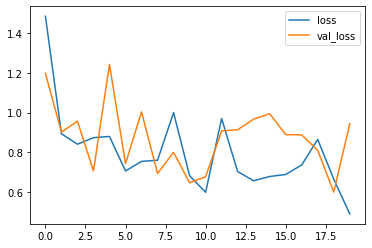

<Figure size 432x288 with 0 Axes>

In [49]:
# loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
plt.savefig('lossVal_loss_ResNet50')

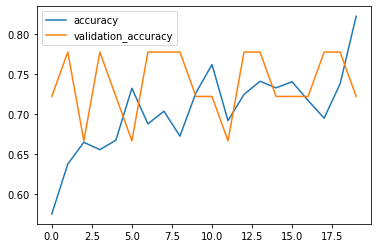

<Figure size 432x288 with 0 Axes>

In [50]:
# accuracy
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.plot(r.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()
plt.savefig('acurracyVal_accuracy_ResNet50')

In [52]:
y_pred = model.predict(test_set)
y_pred

array([[2.5866833e-03, 9.5885759e-03, 9.8631257e-01, 1.5122188e-03],
       [2.3242465e-01, 7.6399034e-01, 3.6919024e-04, 3.2157998e-03],
       [9.9976438e-01, 6.5722014e-07, 1.0967265e-04, 1.2526166e-04],
       [3.5295874e-04, 9.9949586e-01, 1.2388516e-06, 1.5003192e-04],
       [8.6662462e-03, 5.8564478e-05, 9.9127126e-01, 4.0538443e-06],
       [1.6112207e-02, 9.7998458e-01, 7.9640007e-04, 3.1067885e-03],
       [1.5898125e-02, 3.5874212e-01, 2.5667928e-02, 5.9969181e-01],
       [1.2067651e-04, 2.8980734e-05, 9.9949658e-01, 3.5377857e-04],
       [1.4188368e-02, 1.1783976e-03, 1.2860997e-03, 9.8334712e-01],
       [1.8174491e-04, 9.9865913e-01, 5.0037826e-04, 6.5866573e-04],
       [1.1194380e-03, 8.0858994e-01, 1.1849008e-03, 1.8910570e-01],
       [4.8999642e-03, 8.5010558e-01, 5.8521084e-03, 1.3914235e-01],
       [1.6624416e-03, 8.9579481e-01, 2.9585483e-03, 9.9584214e-02],
       [3.9878316e-04, 9.9711776e-01, 4.4773967e-04, 2.0357182e-03],
       [9.5084207e-03, 9.8117101e-

In [53]:
len(y_pred)

18

In [54]:
y_pred.shape

(18, 4)

In [55]:
final_pred = np.argmax(y_pred, axis=1)

In [56]:
final_pred

array([2, 1, 0, 1, 2, 1, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2], dtype=int64)

In [57]:
len(final_pred)

18

In [58]:
final_pred.shape

(18,)

In [59]:
model.save('model_ResNet50.h5')

In [ ]:
model=load_model('model_resnet50.h5')